# Semantic Segmentation - DeepLab V3

### 모듈 리스트

In [4]:
import os
import urllib
import cv2
import numpy as np
from pixellib.semantic import semantic_segmentation
from matplotlib import pyplot as plt
from IPython.display import Image

### PixelLib 모델

In [5]:
# PixelLib 모델 생성

# 모델을 저장할 파일 이름
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5')

# PixelLib 모델의 url
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5'

# 모델 다운로드
urllib.request.urlretrieve(model_url, model_file)

# 세그멘테이션 모델 생성
model = semantic_segmentation()
model.load_pascalvoc_model(model_file)

# semanticAsPascalvoc 지원하는 라벨
class_names = ['background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow',
               'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv']
for i, label in enumerate(class_names):
    print("({}, {})".format(i, label), end = '  ')

(0, background)  (1, aeroplane)  (2, bicycle)  (3, bird)  (4, boat)  (5, bottle)  (6, bus)  (7, car)  (8, cat)  (9, chair)  (10, cow)  (11, diningtable)  (12, dog)  (13, horse)  (14, motorbike)  (15, person)  (16, pottedplant)  (17, sheep)  (18, sofa)  (19, train)  (20, tv)  

### 피사체 추출 함수

In [6]:
def make_mask(path, subject):

    img_orig = cv2.imread(path)
    
    ## 원본 이미지 미리보기
    print("1. Original Image Shape :", img_orig.shape)
    plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
    plt.show()
    
    # 세그멘테이션 모델에 이미지 입력
    segvalues, output = model.segmentAsPascalvoc(path)

    # 모델 입력 결과 확인
    print("2. Model Output Image Shape :", output.shape, ", Class : (", end = ' ')
    for cid in segvalues['class_ids']:
        print(class_names[cid], end = ' ')
    print(")")
        
    plt.imshow(output)
    plt.show()
    
    # colormap
    colormap = np.zeros((256, 3), dtype = int)
    ind = np.arange(256, dtype=int)

    for shift in reversed(range(8)):
        for channel in range(3):
            colormap[:, channel] |= ((ind >> channel) & 1) << shift
        ind >>= 3
    
    # BGR -> RGB
    seg_color = tuple(colormap[subject][::-1])
    
    # seg_color 1(true) or 0(false)
    seg_map = np.all(output==seg_color, axis=-1)
    print("3. Segmentation Map Shape :", seg_map.shape)
    plt.imshow(seg_map, cmap='gray')
    plt.show()
    
    # img_mask 생성 (배경과 피사체 분리)
    img_mask = seg_map.astype(np.uint8) * 255 # 1(true) -> 255 
    color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET) # 색 변경
    
    # 원본 이미지와 대조하여 확인
    print("4. Background and subject contrast")
    img_show = img_orig.copy()
    img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)
    plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
    plt.show()
    
    return [img_orig, img_mask]

### 아웃포커싱 함수

In [7]:
def blur(img_orig, img_mask):
    
    # 전체 블러
    print("Blur the original image")
    img_orig_blur = cv2.blur(img_orig, (100,100)) 
    plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
    plt.show()
    
    # 피사체 제거
    print("Remove subject")
    img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
    img_bg_mask = cv2.bitwise_not(img_mask_color)
    img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
    plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
    plt.show()
    
    # 피사체와 결합
    img_concat = np.where(img_mask_color == 255, img_orig, img_bg_blur)
    blur_img = cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB)
    
    return blur_img

### 아웃포커싱 (사람)

In [8]:
# 사람 사진 경로
me = os.getenv('HOME') + '/aiffel/human_segmentation/images/side.png'

1. Original Image Shape : (2094, 2096, 3)


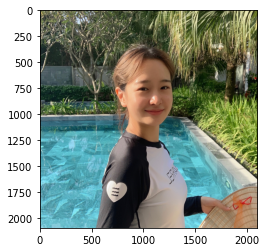

2. Model Output Image Shape : (2094, 2096, 3) , Class : ( background person )


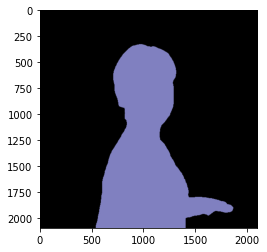

3. Segmentation Map Shape : (2094, 2096)


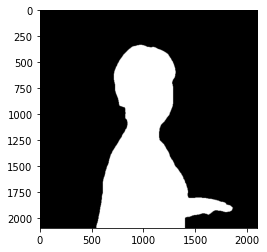

4. Background and subject contrast


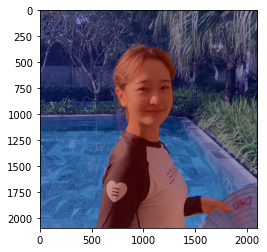

In [9]:
# 사람 사진에서 피사체 추출
me_orig, me_mask = make_mask(me, 15)

Blur the original image


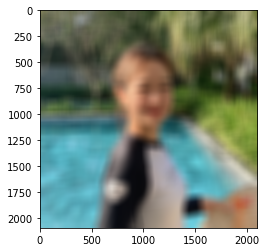

Remove subject


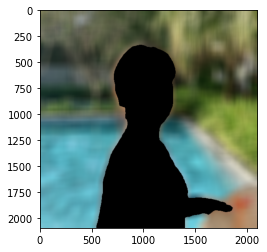

In [10]:
# 아웃포커싱
me_blur = blur(me_orig, me_mask)

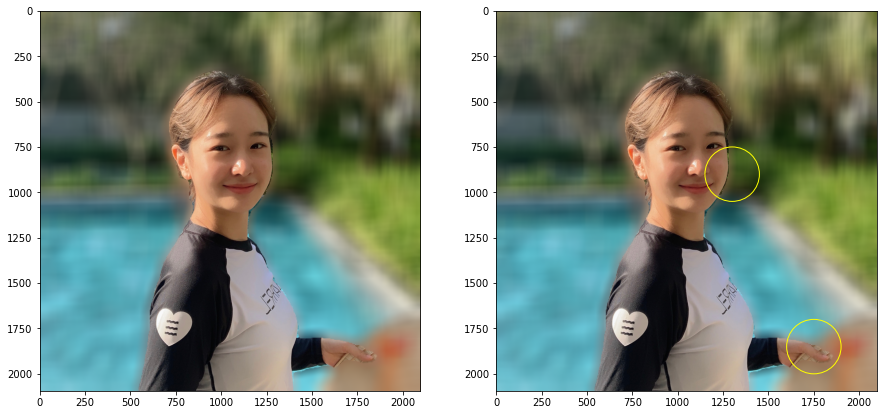

In [11]:
# 아웃포커싱 결과
f, ax = plt.subplots(1, 2, figsize = (15, 15))
ax[0].imshow(me_blur)
ax[1].imshow(me_blur)
ax[1].add_artist(plt.Circle((1300, 900), 150, fill = False, edgecolor = 'yellow'))
ax[1].add_artist(plt.Circle((1750, 1850), 150, fill = False, edgecolor = 'yellow'))
plt.show() 

- 피사체와 배경 사이 다소 어색함
- 물체를 들고 있는 손은 피사체 분리가 원활치 못함

### 아웃포커싱 (고양이)

In [242]:
cat = os.getenv('HOME')+'/aiffel/human_segmentation/images/cat.png'

1. Original Image Shape : (4032, 3024, 3)


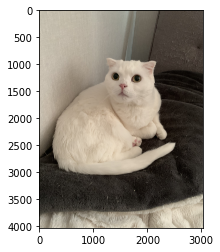

2. Model Output Image Shape : (4032, 3024, 3) , Class : ( background cat )


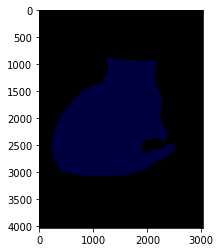

3. Segmentation Map Shape : (4032, 3024)


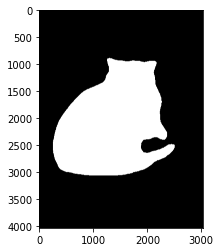

4. Background and subject contrast


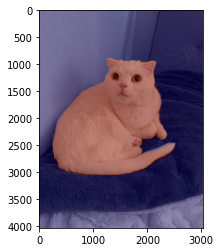

In [243]:
cat_orig, cat_mask = make_mask(cat, 8)

Blur the original image


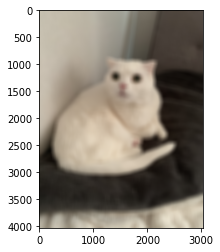

Remove subject


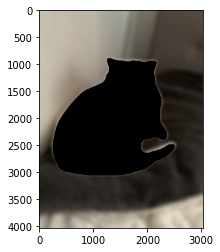

In [244]:
cat_blur = blur(cat_orig, cat_mask)

<Figure size 504x504 with 0 Axes>

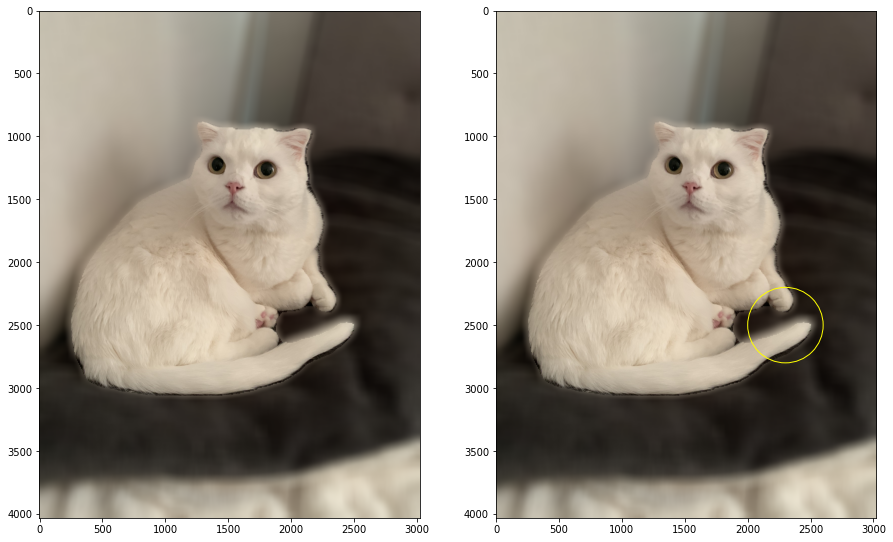

In [245]:
plt.figure(figsize=(7, 7))
f, ax = plt.subplots(1, 2, figsize = (15, 15))
ax[0].imshow(cat_blur)
ax[1].imshow(cat_blur)
ax[1].add_artist(plt.Circle((2300, 2500), 300, fill = False, edgecolor = 'yellow'))
plt.show() 

- 대체로 자연스러움
- 배경에 맞닿아 있는 꼬리 부근은 피사체 분리가 원활치 못함

### 크로마키1 (고양이)

In [246]:
cat2 = os.getenv('HOME')+'/aiffel/human_segmentation/images/standingcat2.jpg'

1. Original Image Shape : (402, 302, 3)


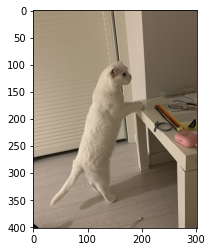

2. Model Output Image Shape : (402, 302, 3) , Class : ( background cat )


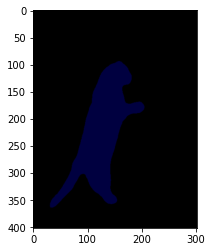

3. Segmentation Map Shape : (402, 302)


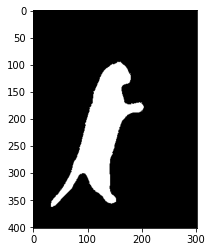

4. Background and subject contrast


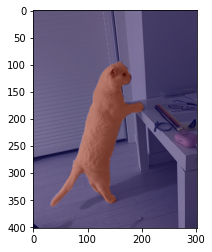

In [247]:
cat2_orig, cat2_mask = make_mask(cat2, 8)

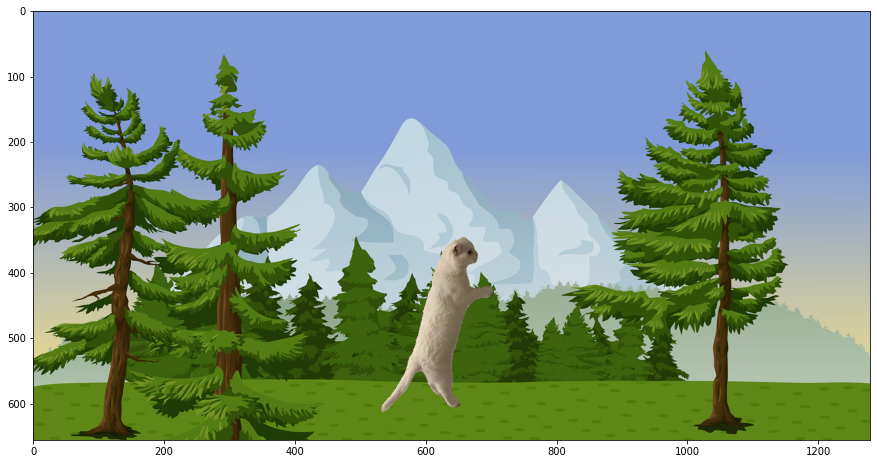

In [248]:
# 크로마키 

# 크로마키 배경 이미지
bg_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/evergreen.png'
bg = cv2.imread(bg_path)

# 추출한 피사체 색 변환
img_mask_color = cv2.cvtColor(cat2_mask, cv2.COLOR_GRAY2BGR)

# 배경에서 피사체 영역 추출
subject_area = bg[250 : 250 + cat2_orig.shape[0], 500 : 500 + cat2_orig.shape[1]]

# 배경에서 추출한 피사체(img_mask_color)를 기준으로 피사체의 이미지를 추가
bg[250 : 250 + cat2_orig.shape[0], 
   500 : 500 + cat2_orig.shape[1]] = np.where(img_mask_color == 255, cat2_orig, subject_area).astype(np.uint8)

# 결과 이미지
chroma_img = cv2.cvtColor(bg, cv2.COLOR_BGR2RGB)

# 확인
plt.figure(figsize=(15, 15))
plt.imshow(chroma_img)
plt.show() 

- 제법 성공적

### 크로마키2 (고양이)

In [249]:
cat3 = os.getenv('HOME')+'/aiffel/human_segmentation/images/standingcat.png'

- 아래 2. Model Output Image Class 결과와 같이 모델이 고양이를 적절히 인식하지 못함 (cat, dog)

1. Original Image Shape : (504, 432, 3)


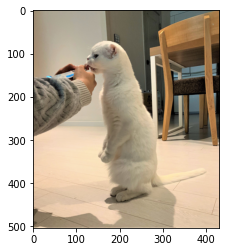

2. Model Output Image Shape : (504, 432, 3) , Class : ( background cat chair diningtable dog person )


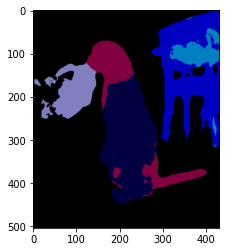

3. Segmentation Map Shape : (504, 432)


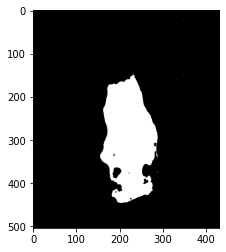

4. Background and subject contrast


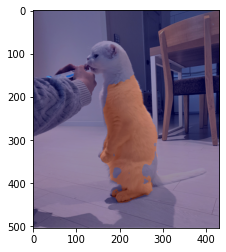

In [250]:
# class = cat(8) 추출
cat3_orig, cat3_mask1 = make_mask(cat3, 8)

1. Original Image Shape : (504, 432, 3)


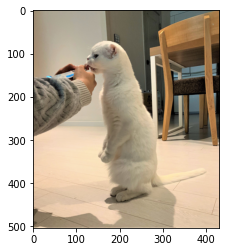

2. Model Output Image Shape : (504, 432, 3) , Class : ( background cat chair diningtable dog person )


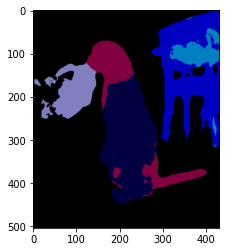

3. Segmentation Map Shape : (504, 432)


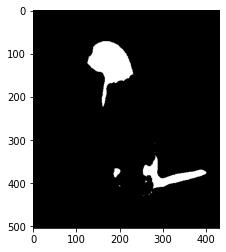

4. Background and subject contrast


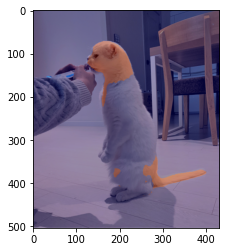

In [251]:
# class = dog(12) 추출
cat3_orig, cat3_mask2 = make_mask(cat3, 12)

- 고양이의 몸통은 cat(8)으로, 고양이의 얼굴과 꼬리는 dog(12)으로 인식하였음
- 추출한 피사체를 더하면 고양이의 전체가 될 것으로 사료됨

Blur the original image


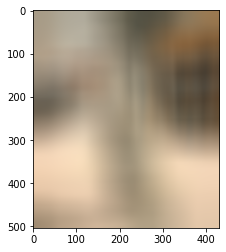

Remove subject


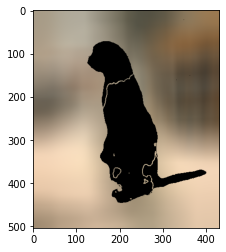

In [252]:
cat3_mask = cat3_mask1 + cat3_mask2
cat3_blur = blur(cat3_orig, cat3_mask)

<Figure size 1080x1080 with 0 Axes>

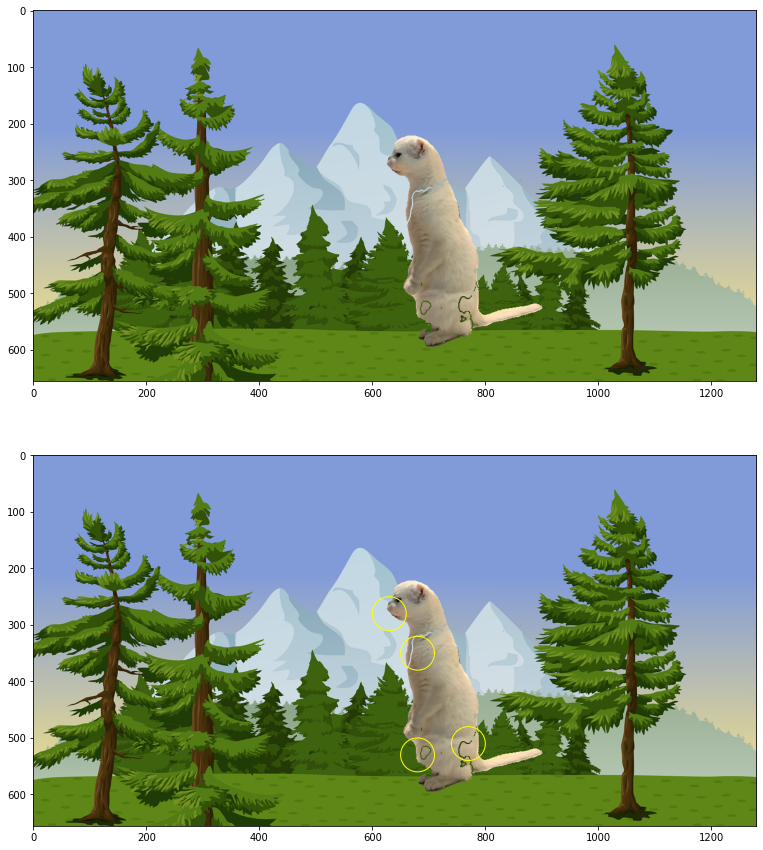

In [253]:
# 크로마키 

# 크로마키 배경 이미지
bg_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/evergreen.png'
bg = cv2.imread(bg_path)

# 추출한 피사체 색 변환
img_mask_color = cv2.cvtColor(cat3_mask, cv2.COLOR_GRAY2BGR)

# 배경에서 피사체 영역 추출
subject_area = bg[150 : 150 + cat3_orig.shape[0], 500 : 500 + cat3_orig.shape[1]]

# 배경에서 추출한 피사체(img_mask_color)를 기준으로 피사체의 이미지를 추가
bg[150 : 150 + cat3_orig.shape[0], 
   500 : 500 + cat3_orig.shape[1]] = np.where(img_mask_color == 255, cat3_orig, subject_area).astype(np.uint8)

# 결과 이미지
chroma_img = cv2.cvtColor(bg, cv2.COLOR_BGR2RGB)

# 확인
plt.figure(figsize=(15, 15))
f, ax = plt.subplots(2, 1, figsize = (15, 15))
ax[0].imshow(chroma_img)
ax[1].imshow(chroma_img)
ax[1].add_artist(plt.Circle((630, 280), 30, fill = False, edgecolor = 'yellow'))
ax[1].add_artist(plt.Circle((680, 350), 30, fill = False, edgecolor = 'yellow'))
ax[1].add_artist(plt.Circle((680, 530), 30, fill = False, edgecolor = 'yellow'))
ax[1].add_artist(plt.Circle((770, 510), 30, fill = False, edgecolor = 'yellow'))

plt.show() 

- 입 부근이 적절히 추출되지 않았음
- 모델이 몸통은 cat(8)으로 인식하였으나, 얼굴과 꼬리는 dog(12)으로 오인하였음
- 추출한 mask 여러개를 더한 결과, 고양이 몸이 완전하게 추출되지 않았음

## 문제점과 개선방안

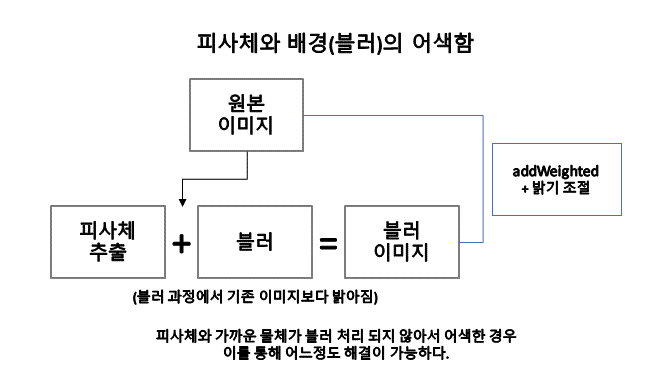

In [9]:
Image("img/sol1.png")

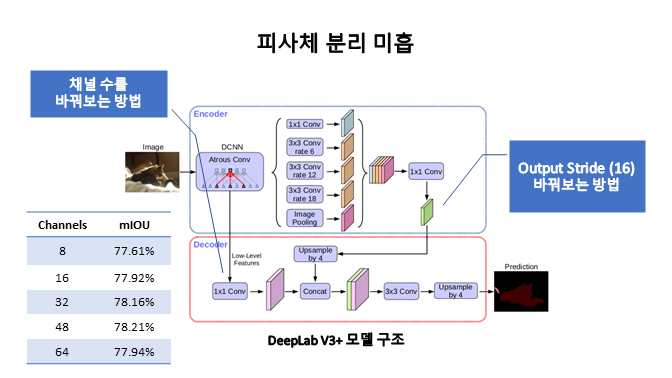

In [10]:
Image("img/sol2.png")

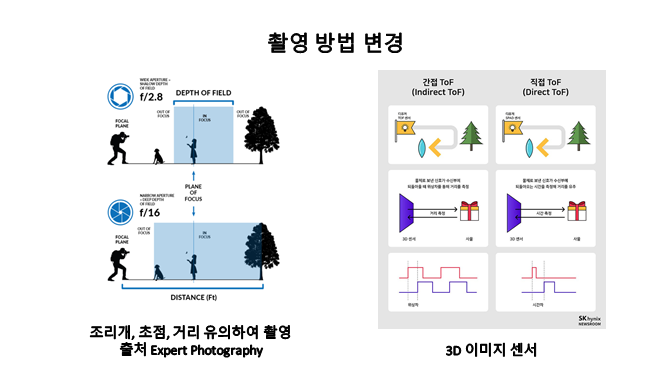

In [11]:
Image("img/sol3.png")